# Classification of Heart Disease Using K-Nearest Neighbor

## Introduction
Many people die of cardiovascular diseases without knowing they have a problem with their heart. Unexpected deaths as such can be prevented with early diagnosis of cardiovascular issues and proper medication. In this project, we are trying to answer: Can available patient data and the KNN classification algorithm be used to detect the presence of heart diseases? If so, how accurate could it be and how to use it correctly in actual practice? The heart disease dataset we are using is obtained from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). It contains 303 patient instances and 14 attributes collected from Cleveland.

## Methods and Results
#### 1. Download and Read the original dataset on the web

In [2]:
# Load packages that will be used.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

In [3]:
# Set the value of seed to ensure reproducibility
set.seed(200)

In [4]:
# Download the dataset from the web
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
download.file(url,destfile='HeartDisease_Cleveland.csv')

In [6]:
# Read the 'HeartDisease_Cleveland.csv' file into a dataframe (a tibble)
heart_cleve <- read_csv('HeartDisease_Cleveland.csv',col_names = FALSE)
head(heart_cleve)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [7]:
# Rename the column names and Format the column types
heart_cleve <- rename(heart_cleve, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               diagnosis = X14) %>% 
            mutate(diagnosis = as_factor(diagnosis),ca = as.numeric(ca),thal = as.numeric(thal))
head(heart_cleve)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [8]:
# Wrangle the `diagnosis` column: 0 indicates absence of heart disease and 1 indicates presence of heart disease.

heart_cleve$diagnosis[heart_cleve$diagnosis==2] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==3] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==4] <- 1
head(heart_cleve)

# Source: https://www.geeksforgeeks.org/how-to-replace-specific-values-in-column-in-r-dataframe/

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


#### 3. Exploratory Data Analysis: Summary statistics of the Training data

In [9]:
# Split the dataset into training and test sets

heart_cleve_selected <- heart_cleve %>%
                        select(age, trestbps, chol, thalach, oldpeak, diagnosis)
heart_split <- initial_split(heart_cleve_selected,prop=0.75,strata=diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [11]:
# Summary Statistics of the training data

# Number of observations in each class
heart_sum_class <- heart_train %>% 
                group_by(diagnosis) %>%
                summarise(n=n())
heart_sum_class

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
0,123
1,105


In [17]:
# Summary statistics of predictor variables used in analysis
options(digits=2)
heart_percentile <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(quantile,na.rm = TRUE) 

heart_1stQ <- heart_percentile %>%
                select('25%') %>%
                t()%>%
                as.vector()

heart_3rdQ <- heart_percentile %>%
                select('75%') %>%
                t() %>%
                as.vector()

heart_mean <- heart_train%>% 
                    select(-diagnosis) %>%
                    map_df(mean,na.rm = TRUE)

heart_min <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(min,na.rm = TRUE)

heart_max <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(max,na.rm = TRUE)

heart_median <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(median,na.rm = TRUE)

heart_range <- heart_max - heart_min

heart_missing <- colSums(is.na(heart_train %>% select(-diagnosis)))
# Source: https://stackoverflow.com/questions/26273663/r-how-to-total-the-number-of-na-in-each-col-of-data-frame

heart_sum_pred <- rbind(heart_min, heart_1stQ, heart_median,heart_mean, heart_3rdQ, heart_max, heart_range, heart_missing) %>%
                    mutate(Statistics = c('Min','First Quartile','Median','Mean','Third Quartile','Max','Range','# of Missing Value'),.before = age)
heart_sum_pred

Statistics,age,trestbps,chol,thalach,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,29,94,126,71,0.00
First Quartile,48,120,210,139,0.00
Median,56,130,238,154,0.75
Mean,55,132,245,150,1.01
Third Quartile,61,140,274,168,1.60
Max,77,200,564,202,6.20
Range,48,106,438,131,6.20
# of Missing Value,0,0,0,0,0.00


#### 4. Exploratory Data Analysis: Visualization of the Training data

In [18]:
library(gridExtra)

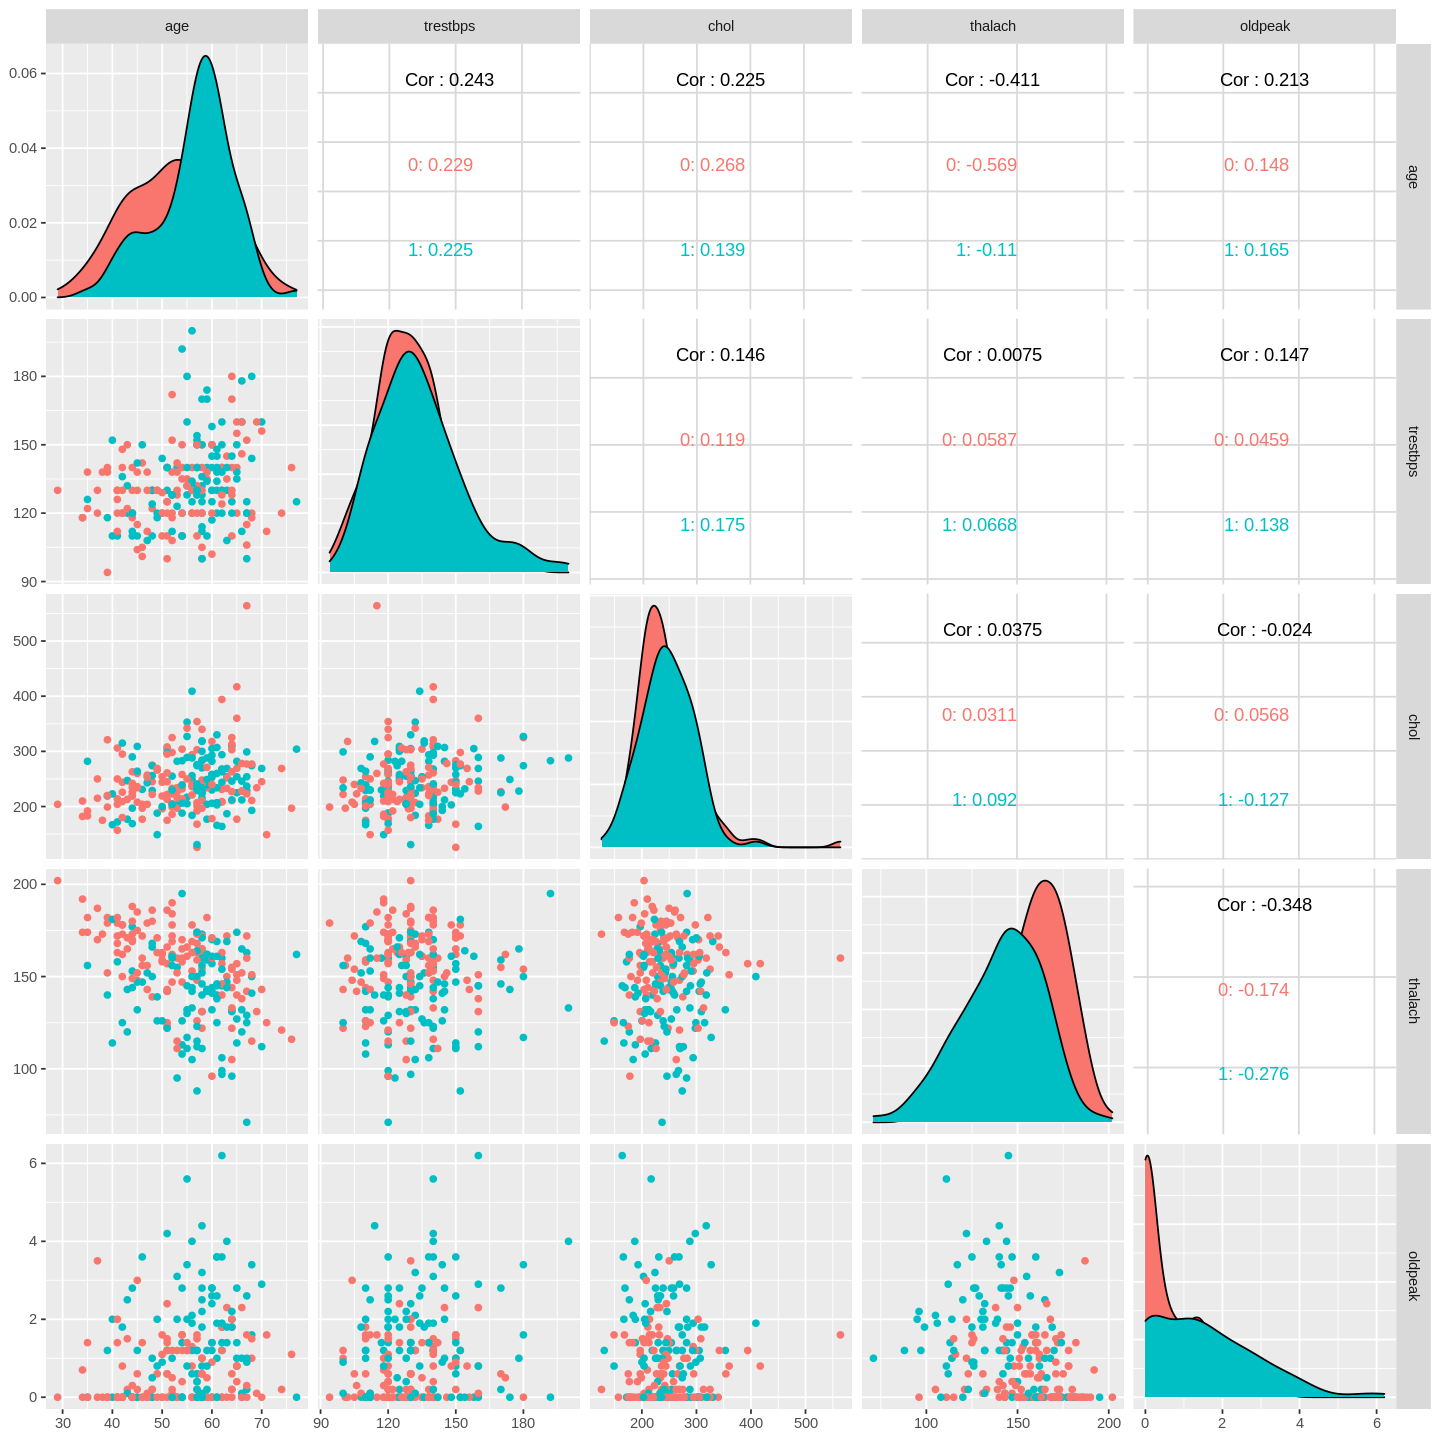

In [19]:
options(repr.plot.width=12,repr.plot.height = 12)

ggpairs(heart_train, columns = 1:5, ggplot2::aes(colour = diagnosis)) 

# Source: https://www.r-graph-gallery.com/199-correlation-matrix-with-ggally.html#:~:text=The%20ggpairs()%20function%20of,is%20available%20on%20the%20diagonal.

#### 5. Model Tuning and Cross-validation

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


! Fold1: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold2: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold3: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold4: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold5: internal: No observations were detected in `truth` for level(s): '2', '3...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.58,5,0.021,Model1
1,roc_auc,hand_till,0.58,5,0.019,Model1
21,accuracy,multiclass,0.67,5,0.029,Model2
21,roc_auc,hand_till,0.74,5,0.038,Model2
41,accuracy,multiclass,0.68,5,0.034,Model3
41,roc_auc,hand_till,0.78,5,0.032,Model3
61,accuracy,multiclass,0.68,5,0.026,Model4
61,roc_auc,hand_till,0.77,5,0.029,Model4
81,accuracy,multiclass,0.67,5,0.029,Model5


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.58,5,0.021,Model1
21,accuracy,multiclass,0.67,5,0.029,Model2
41,accuracy,multiclass,0.68,5,0.034,Model3
61,accuracy,multiclass,0.68,5,0.026,Model4
81,accuracy,multiclass,0.67,5,0.029,Model5


neighbors
<dbl>
41


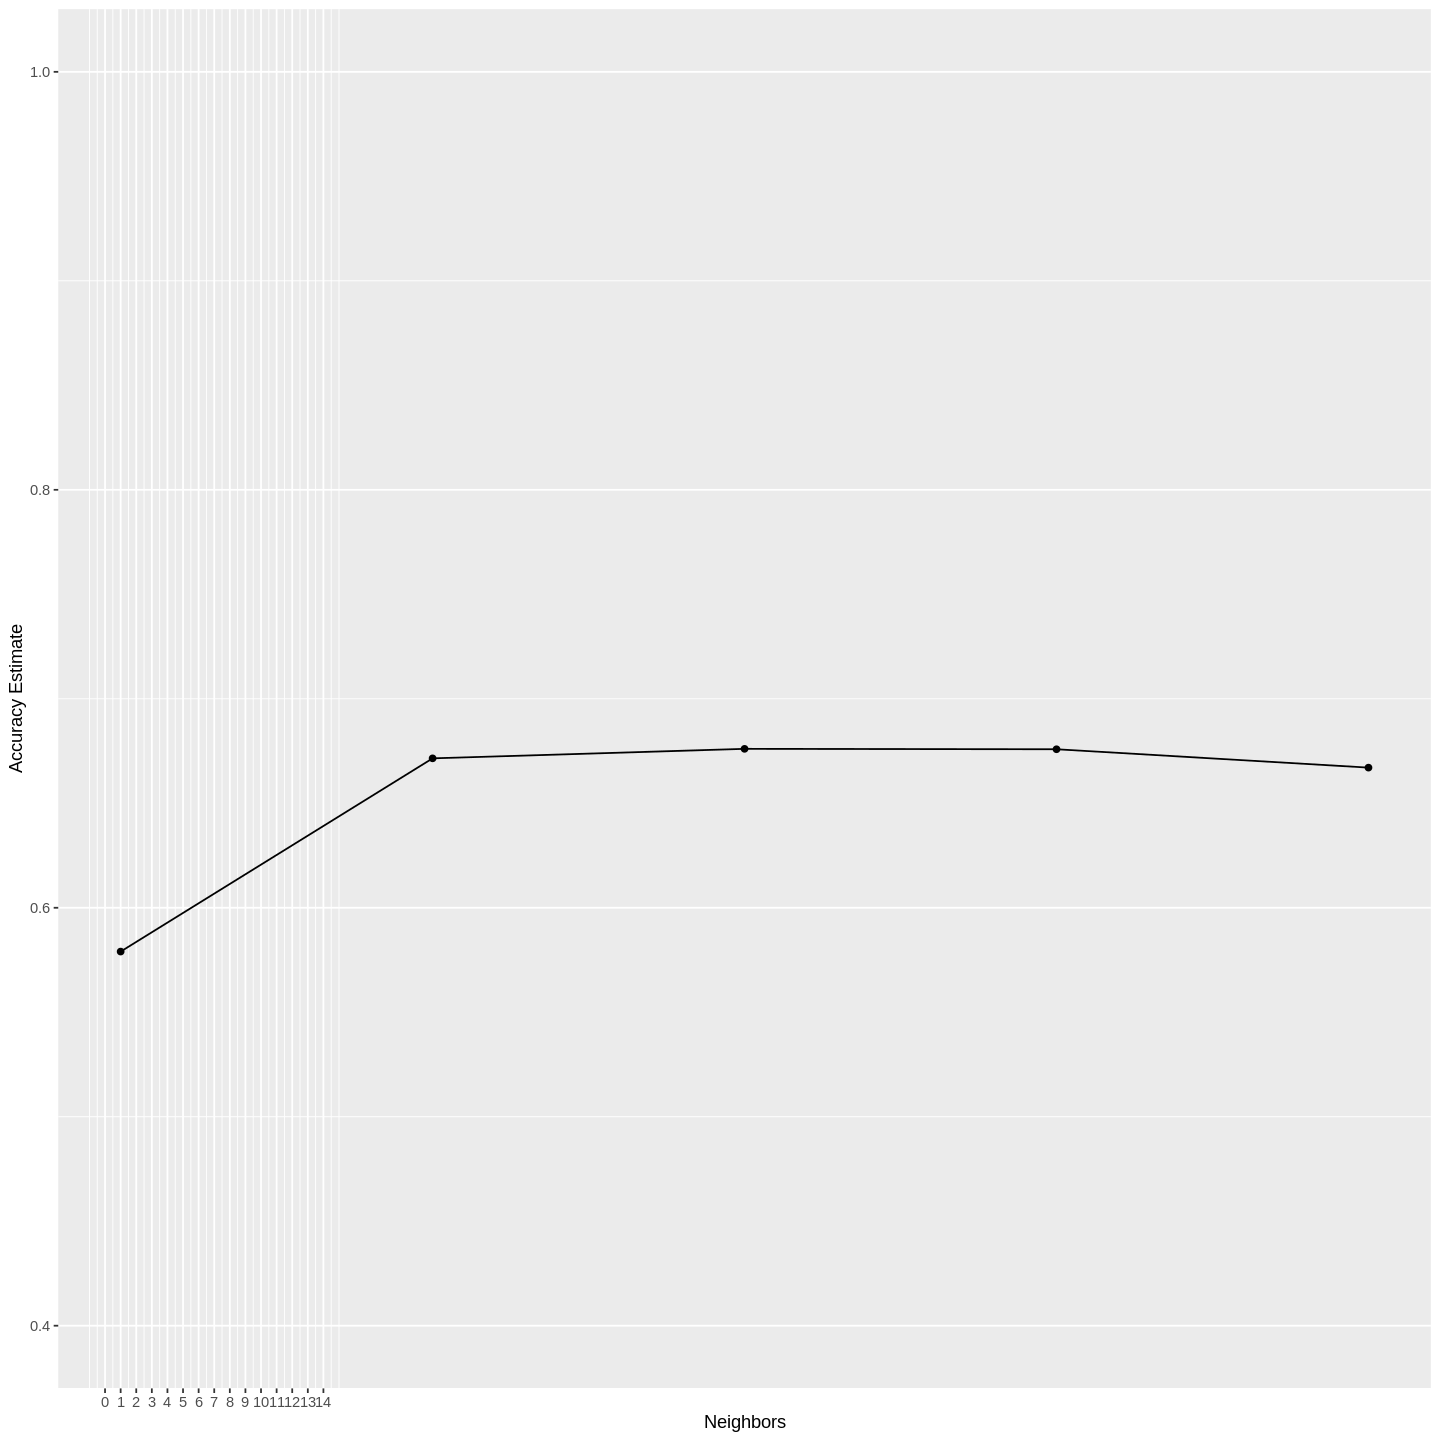

In [26]:
# Create the recipe that specifies class label and predictors, as well as preprocessing steps for all variables.
heart_recipe <- recipe(diagnosis ~ age + trestbps + chol + thalach + oldpeak, data = heart_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
heart_recipe


# Create a KNN model specification
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")
heart_tune


# Split the training data for cross-validation
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)


# Create a dataframe with a neighbors variable that contains the sequence of values of K to try
k_vals <- tibble(neighbors=seq(from = 1, to = 100, by = 20))


# Create a workflow to train KNN classifiers and estimate the classifier accuracy for a range of K values.
heart_results <- workflow() %>%
                    add_recipe(heart_recipe) %>%
                    add_model(heart_tune) %>%
                    tune_grid(resamples = heart_vfold, grid = k_vals) %>%
                    collect_metrics()
heart_results


# Filter the accuracy metric of classifers trained with different value of K
accuracies <- heart_results %>%
                    filter(.metric == "accuracy")
# accuracies


# Create a plot for accuracy vs. K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) +  
      scale_y_continuous(limits = c(0.4, 1.0), breaks = seq (0.4, 1, by = 0.05))
accuracy_vs_k


# Pulling the optimal value of K
best_k <- accuracies %>%
            arrange(desc(mean)) %>%
            slice(1) %>%
            select(neighbors) %>%
            pull()
best_k

#### 6. Build the KNN Classifier with the Optimal K value

## Methods
### 1. Data Analysis Processes
#### Data Exploration  
Initially, we will review heart disease-related literature to get an intuition about the predictor variables to include in the classification task. If possible, we may explore further into predictor variable selection using more advanced methods like forward selection.

#### Data Modeling（training set） 

- ***Data Splitting***  
  The dataset will be split into two sets with corresponding percentage assignment: training set (75%) and testing set (25%). 

- ***Model Training***  
  The *K-Nearest Neighbor* algorithm is used to train the classifier for heart disease classification. To find the optimal classifier, we will go through the model tuning process to find the value of K that has the highest prediction accuracy.
  
- ***Model Tuning***  
  Cross-validation is used to tune the classifier. The training set will be split into C folds and iteratively, C-1 folds will be used as the training set to train the classifier and 1 fold will be used as a validation set to calculate the prediction accuracy. In our project, C is chosen to be either 5 or 10.
  
#### Model Testing and Performance Evaluation (testing set)  
The prediction results and the true results are compared to evaluate the prediction power of the classifier. Specifically, the *Accuracy* metric is used for performance evaluation. A confusion matrix will be generated to present the predicted and correct labels.

### 2. Predictors Selection
We will use the variables of `age`, `trestbps` (resting blood pressure on admission to hospital in mm Hg), `chol` (serum cholesterol in mg/dl), `thalach` (maximum heart rate achieved), and `oldpeak` (ST depression induced by exercise relative to rest), as predictors for diagnosis. They are numerical variables. We selected them among the 13 available variables because they contain continuous values suited for the KNN algorithm and are believed to be strongly related to the presence of heart diseases.

### 3. Results Visualization
We may use the line plot together with the scatter plot to present the K-Accuracy relationship to find out the opitmal value of K to train the classifier. We may also try to plot the actual lables and predicted lables using scatter plot to see their mappings and to present the prediction results.

## Expected Outcomes and Significance   
We are expecting that the medical information that can be readily collected from the patients together with the classifier built under the KNN algorithm can facilitate the diagnosis and prediction of heart diseases. If our project can support the above finding, we will be able to draw insights into building decision support systems to help clinicians to make better decisions on the necessity to take precautionary steps. Future questions would be what other relevant variables can be included in the model and how we could further improve the prediction accuracy of the classifier.